<a href="https://colab.research.google.com/github/duckbillLvr/software-lecture/blob/main/lecture5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install finterstellar

     |████████████████████████████████| 109 kB 5.1 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [3]:
import finterstellar as fs

### 3. 영업 효율이 좋은 기업, GP/A

> $$GP/A = \frac{매출총이익(Gross Profit)}{총자산}$$

- 싸지만 수익성이 떨어지는 종목을 매수하거나 비싸지만 수익성이 높은 종목을 매도하는 것을 방지할 수 있다.

In [ ]:
df = fs.fn_single(otp='16487125231099712210', symbol='LMT', window='T')

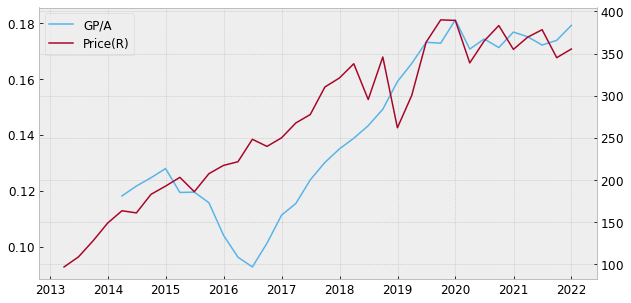

In [ ]:
df['Avg Assets'] = (df['Total Assets'] + df['Total Assets'].shift(4)) / 2
df['GP/A'] = df['Gross Profit'] / df['Avg Assets']
fs.draw_chart(df, left='GP/A', right='Price')

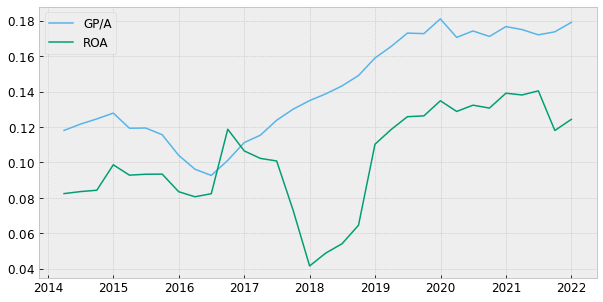

In [ ]:
# GP/A 와 ROA 비교
df['ROA'] = df['Net Income'] / df['Avg Assets']
fs.draw_chart(df, left=['GP/A', 'ROA'])

- GP/A 백테스트

In [14]:
terms = fs.set_terms(trade_start='2011Q1', trade_end='2021Q1')
data = {}
for t in terms:
  data[t] = fs.fn_consolidated(otp='16487125231099712210', term=t)

2010Q4...OK
2011Q1...OK
2011Q2...OK
2011Q3...OK
2011Q4...OK
2012Q1...OK
2012Q2...OK
2012Q3...OK
2012Q4...OK
2013Q1...OK
2013Q2...OK
2013Q3...OK
2013Q4...OK
2014Q1...OK
2014Q2...OK
2014Q3...OK
2014Q4...OK
2015Q1...OK
2015Q2...OK
2015Q3...OK
2015Q4...OK
2016Q1...OK
2016Q2...OK
2016Q3...OK
2016Q4...OK
2017Q1...OK
2017Q2...OK
2017Q3...OK
2017Q4...OK
2018Q1...OK
2018Q2...OK
2018Q3...OK
2018Q4...OK
2019Q1...OK
2019Q2...OK
2019Q3...OK
2019Q4...OK
2020Q1...OK
2020Q2...OK
2020Q3...OK
2020Q4...OK


In [ ]:
s, signal = {}, {}
for t in terms:
  prev_t = fs.quarters_before(terms, t, 4)
  data[t]['Avg Assets'] = (data[t]['Total Assets'] + data[prev_t]['Total Assets']) / 2
  data[t]['GP/A'] = data[t]['Gross Profit'] / data[t]['Avg Assets']
  data[t].loc[(data[t]['Gross Profit'] < 0) | (data[t]['Avg Assets'] < 0) | (data[t]['Total Assets'] < 0), 'GP/A'] = float('nan')
  s[t] = fs.fn_filter(data[t], by='GP/A', floor=0, n=30, asc=False)
  signal[t] = list(s[t].index)

df = fs.backtest(signal = signal, data=data, m=3, cost=.001)

CAGR: 14.13%
Accumulated return: 275.53%
Investment period: 10.0yrs
Sharpe ratio: 1.03
MDD: -38.17%


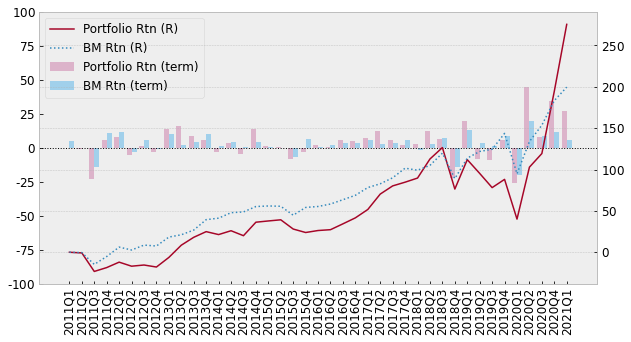

In [ ]:
fs.draw_return(df)

- PER 전략 테스트

In [ ]:
s = {}
signal = {}
for t in terms:
  data[t]['PER'] = data[t]['Price_M3'] / data[t]['EPS']
  s[t] = fs.fn_filter(data[t], by='PER', floor=1, cap = 10, asc=True)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)

CAGR: 6.31%
Accumulated return: 84.45%
Investment period: 10.0yrs
Sharpe ratio: 0.65
MDD: -14.98%


- PER, GP/A 합성전략 테스트

In [ ]:
s, s1, s2, signal = {}, {}, {}, {}
for t in terms:
  #GP/A
  prev_t = fs.quarters_before(terms, t, 4)
  data[t]['Avg Assets'] = (data[t]['Total Assets'] + data[prev_t]['Total Assets']) / 2
  data[t]['GP/A'] = data[t]['Gross Profit'] / data[t]['Avg Assets']
  data[t].loc[(data[t]['Gross Profit'] < 0) | (data[t]['Avg Assets'] < 0) | (data[t]['Total Assets'] < 0), 'GP/A'] = float('nan')
  #PER
  data[t]['PER'] = data[t]['Price_M3'] / data[t]['EPS']
  s1[t] = fs.fn_score(data[t], by='PER', method='relative', floor=1,cap=10, asc=True)
  s2[t] = fs.fn_score(data[t], by='GP/A', method='relative', floor=0, asc=False)
  s[t] = fs.combine_score(s1[t], s2[t], n=30)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)

CAGR: 6.21%
Accumulated return: 82.75%
Investment period: 10.0yrs
Sharpe ratio: 0.28
MDD: -54.95%


In [ ]:
# PBR 단독 성과
s = {}
signal = {}
for t in terms:
  data[t]['PBR'] = data[t]['Price_M3'] / (data[t]['Shareholders Equity'] / data[t]['Shares'])
  s[t] = fs.fn_filter(data[t], by='PBR', floor=.1, cap = 1,n=30, asc=True)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)

CAGR: 31.04%
Accumulated return: 1395.90%
Investment period: 10.0yrs
Sharpe ratio: 2.86
MDD: -38.99%


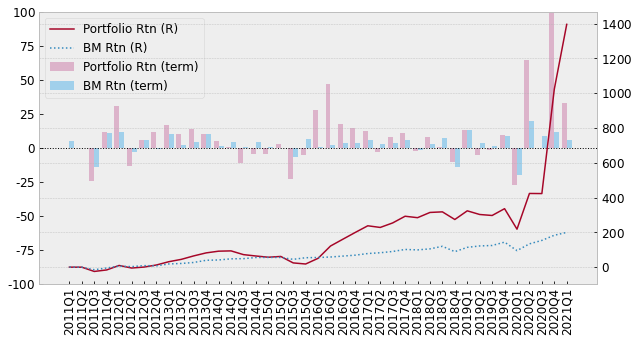

In [ ]:
fs.draw_return(df)

In [ ]:
# PBR, GP/A 합성 백테스트
s, s1, s2, signal = {}, {}, {}, {}
for t in terms:
  #GP/A
  prev_t = fs.quarters_before(terms, t, 4)
  data[t]['Avg Assets'] = (data[t]['Total Assets'] + data[prev_t]['Total Assets']) / 2
  data[t]['GP/A'] = data[t]['Gross Profit'] / data[t]['Avg Assets']
  data[t].loc[(data[t]['Gross Profit'] < 0) | (data[t]['Avg Assets'] < 0) | (data[t]['Total Assets'] < 0), 'GP/A'] = float('nan')
  #PBR
  data[t]['PBR'] = data[t]['Price_M3'] / (data[t]['Shareholders Equity'] / data[t]['Shares'])
  s1[t] = fs.fn_score(data[t], by='PBR', method='relative', floor=.1,cap=1, asc=True)
  s2[t] = fs.fn_score(data[t], by='GP/A', method='relative', floor=0, asc=False)
  s[t] = fs.combine_score(s1[t], s2[t], n=30)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)

CAGR: 23.41%
Accumulated return: 720.54%
Investment period: 10.0yrs
Sharpe ratio: 1.67
MDD: -48.28%


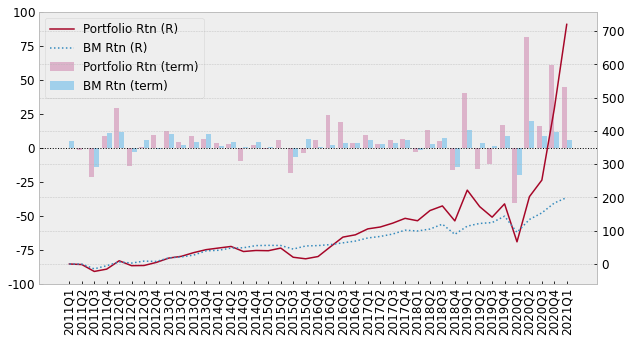

In [ ]:
fs.draw_return(df)

### 4. 안정성 지표
- 전체 자산 중 부채가 얼마나 많은지를 따지는 부채비율, 부채 중에서도 차입금비율을 봐야 한다.
- 부채가 많으면 기업은 채권자의 손에 넘어간다.


부채비율이 100이상이라면 부채가 자본보다 많은 것이다.
> $$부채비율 = \frac{총부채(Total\,Liabilities)}{총자본(Shareholders\,Equity)} \times 100$$  


- 부채 비율이 높다고 해서 반드시 나쁜 것은 아니다.
- 차임금은 이자 비용을 발생시켜 기업의 손익에 직접적인 영향을 미친다.


> $$ 차입금비율 = \frac{단기차입임(Current\,Debt) + 장기차입금(Long\,Term,Debt)}{총자본(Shareholders\,Equity)} \times 100$$


In [ ]:
# 부채비율과 차입금비율 계산
df = fs.fn_single(otp='16487125231099712210', symbol='UBER', window='T') # 우버의 재무 데이터

In [ ]:
df['Liability/Equity'] = df['Total Liabilities'] / df['Shareholders Equity']
df['Debt/Equity'] = (df['Long Term Debt'] + df['Current Debt']) / df['Shareholders Equity']
df[['Liability/Equity', 'Debt/Equity']].tail()

,Liability/Equity,Debt/Equity
2020-12-31,1.59,0.85
2021-03-31,1.51,0.72
2021-06-30,1.45,0.69
2021-09-30,1.62,0.80
2021-12-31,1.62,0.80


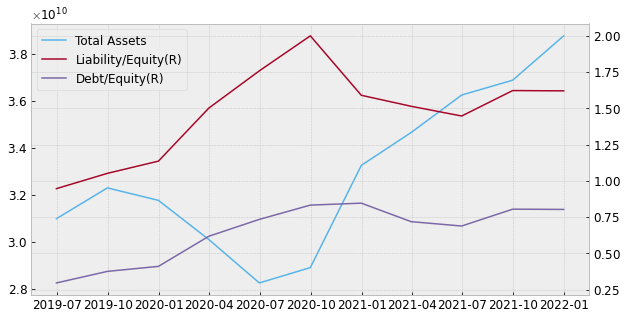

In [ ]:
fs.draw_chart(df, left='Total Assets', right=['Liability/Equity', 'Debt/Equity'])

- 부채비율평가: 부채비율은 늘어나고 자산은 줄어드는 형태로 가장 경계해야할 모양의 그래프
- 차입금비율평가 : 역시 2020년 7월 자산이 감소하는면서 부채 비율은 올라가는 형태이다.

In [ ]:
# Liability/Equity 백테스팅
s = {}
signal = {}
for t in terms:
  data[t]['Liability/Equity'] = data[t]['Total Liabilities'] / data[t]['Shareholders Equity']
  data[t].loc[(data[t]['Shareholders Equity'] < 0), 'Liability/Equity'] = float('nan')
  s[t] = fs.fn_filter(data[t], by='Liability/Equity', floor=0, n=30, asc=True)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)

CAGR: 4.93%
Accumulated return: 61.90%
Investment period: 10.0yrs
Sharpe ratio: 0.26
MDD: -32.60%


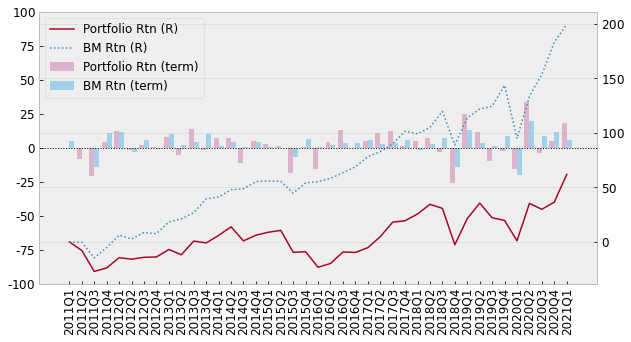

In [ ]:
fs.draw_return(df)

In [28]:
# PER + Liability/Equity 백테스팅
s1, s2, s, signal = {}, {}, {}, {}
for t in terms:
  # PER
  data[t]['PER'] = data[t]['Price_M3'] / data[t]['EPS']
  # Liability/Equity
  data[t]['Liability/Equity'] = data[t]['Total Liabilities'] / data[t]['Shareholders Equity']
  data[t].loc[(data[t]['Shareholders Equity'] < 0), 'Liability/Equity'] = float('nan')
  s1[t] = fs.fn_filter(data[t], by='PER', floor=1, cap=10, asc=True)
  s2[t] = fs.fn_filter(data[t], by='Liability/Equity', floor=0, n=1000, asc=True)
  s[t] = fs.combine_signal(s1[t], s2[t], how='and', n=30)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)

CAGR: 0.82%
Accumulated return: 8.52%
Investment period: 10.0yrs
Sharpe ratio: 0.03
MDD: -59.25%


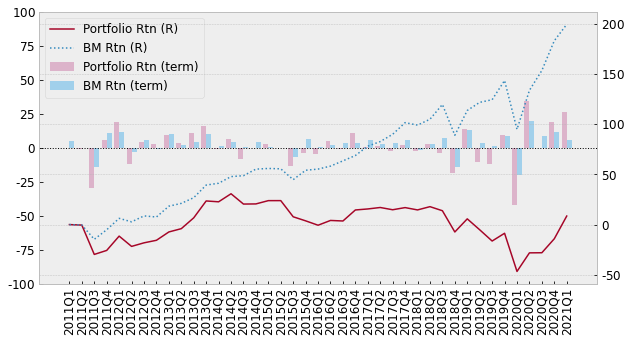

In [29]:
fs.draw_return(df)

In [ ]:
# PBR + Liability/Equity 백테스팅
s1, s2, s, signal = {}, {}, {}, {}
for t in terms:
  # PBR
  data[t]['PBR'] = data[t]['Price_M3'] / (data[t]['Shareholders Equity'] / data[t]['Shares'])
  # Liability/Equity
  data[t]['Liability/Equity'] = data[t]['Total Liabilities'] / data[t]['Shareholders Equity']
  data[t].loc[(data[t]['Shareholders Equity'] < 0), 'Liability/Equity'] = float('nan')
  s1[t] = fs.fn_filter(data[t], by='PBR', floor=.1, cap=1, asc=True)
  s2[t] = fs.fn_filter(data[t], by='Liability/Equity', floor=0, n=1000, asc=True)
  s[t] = fs.combine_signal(s1[t], s2[t], how='and', n=30)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)

CAGR: 20.03%
Accumulated return: 521.62%
Investment period: 10.0yrs
Sharpe ratio: 1.18
MDD: -46.77%


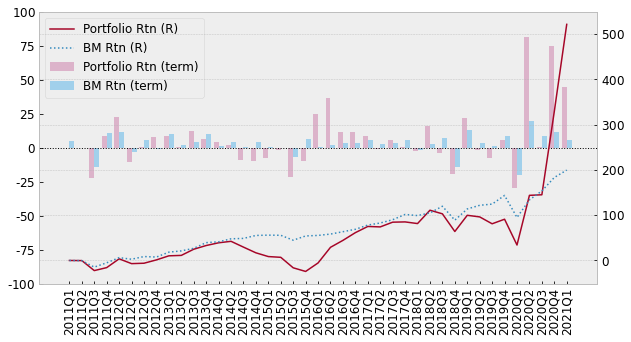

In [ ]:
fs.draw_return(df)

### 5. 쑥쑥 자라는 기업, 성장률 지표

 $$성장률 기본 공식 = \frac{현재값-기준값}{기준값}$$  
 $$매출액 증가율(Revenue\,Growth) = \frac{현재\,매출액-매출액\,기준값}{매출액\,기준값}$$  
 $$당기순이익 증가율(Net\,Income\,Growth) = \frac{현재\,당기순이익-당기순이익\,기준값}{당기순이익\,기준값}$$  
 $$자산 증가율(Asset Growth) = \frac{현재자산-자산\,기준값}{자산\,기준값}$$

In [5]:
# 넷플릭스 재무데이터 불러오기
df = fs.fn_single(otp='16487125231099712210', symbol='NFLX', window='T')

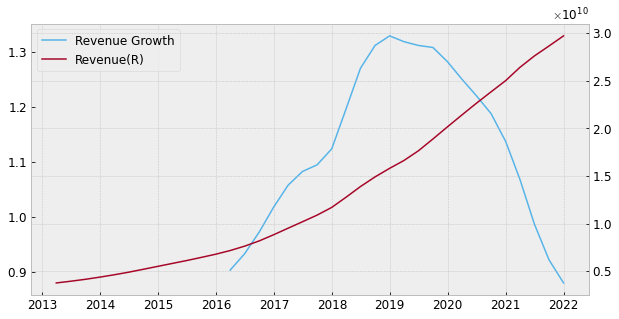

In [8]:
# 매출액 증가율 (3년간)
df['Revenue Growth'] = (df['Revenue'] - df['Revenue'].shift(12)) / abs(df['Revenue'].shift(12))
fs.draw_chart(df, left='Revenue Growth', right='Revenue')

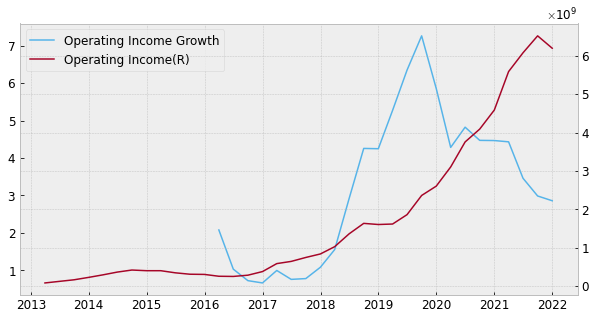

In [11]:
# 영업이익 증가율 (3년간)
df['Operating Income Growth'] = (df['Operating Income'] - df['Operating Income'].shift(12)) / abs(df['Operating Income'].shift(12))
fs.draw_chart(df, left='Operating Income Growth', right='Operating Income')

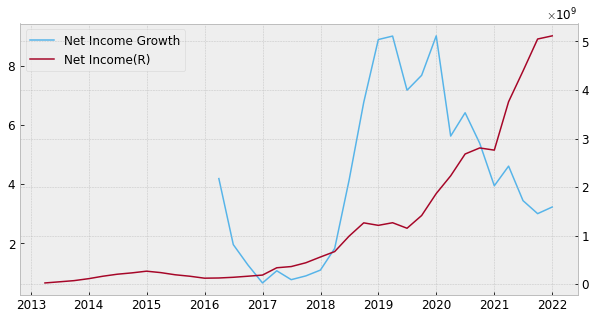

In [12]:
# 순이익 증가율(3년간)
df['Net Income Growth'] = (df['Net Income'] - df['Net Income'].shift(12)) / abs(df['Net Income'].shift(12))
fs.draw_chart(df, left='Net Income Growth', right='Net Income')

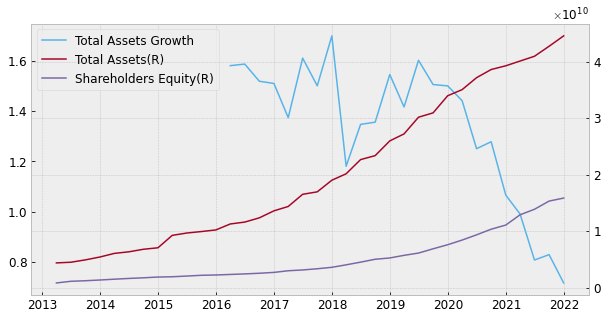

In [13]:
# 자산 성장률
df['Total Assets Growth'] = (df['Total Assets'] - df['Total Assets'].shift(12)) / abs(df['Total Assets'].shift(12))
fs.draw_chart(df, left='Total Assets Growth', right=['Total Assets', 'Shareholders Equity'])

CAGR: 16.72%
Accumulated return: 195.38%
Investment period: 7.0yrs
Sharpe ratio: 0.82
MDD: -30.30%


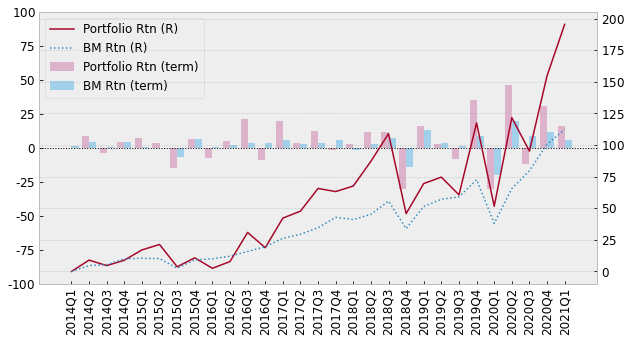

In [31]:
# 매출액 증가율 백테스팅
s, signal = {}, {}
for t in terms:
  if list(terms).index(t) >= 12:
    prev_t = fs.quarters_before(terms, t, 12) # 12분기
    data[t]['Revenue Growth'] = (data[t]['Revenue'] - data[prev_t]['Revenue']) / abs(data[prev_t]['Revenue'])
    s[t] = fs.fn_filter(data[t], by='Revenue Growth', floor=0, n=30, asc=False)
    signal[t] = list(s[t].index)
df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 7.58%
Accumulated return: 66.85%
Investment period: 7.0yrs
Sharpe ratio: 0.35
MDD: -47.25%


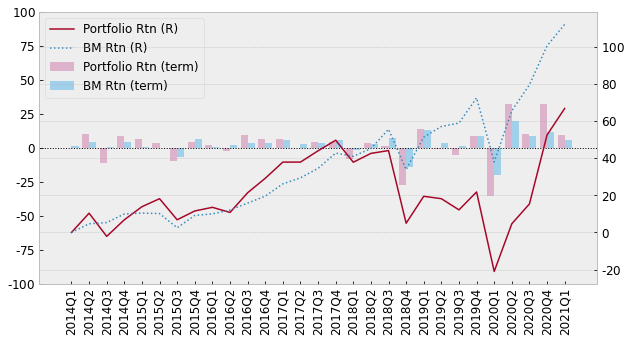

In [32]:
# 영업이익 증가율 백테스팅
s, signal = {}, {}
for t in terms:
  if list(terms).index(t) >= 12:
    prev_t = fs.quarters_before(terms, t, 12) # 12분기
    data[t]['Operating Income Growth'] = (data[t]['Operating Income'] - data[prev_t]['Operating Income']) / abs(data[prev_t]['Operating Income'])
    s[t] = fs.fn_filter(data[t], by='Operating Income Growth', floor=0, n=30, asc=False)
    signal[t] = list(s[t].index)
df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 4.12%
Accumulated return: 32.68%
Investment period: 7.0yrs
Sharpe ratio: 0.21
MDD: -32.60%


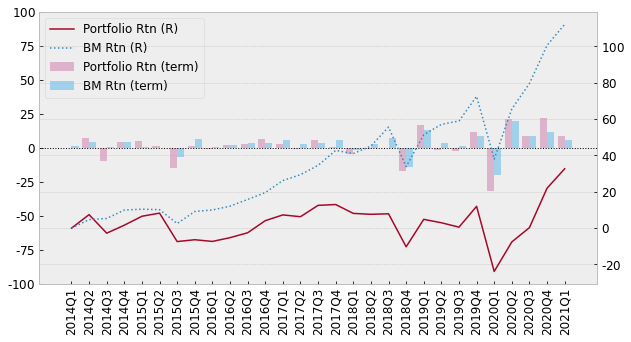

In [33]:
# 당기순이익 증가율
s, signal = {}, {}
for t in terms:
  if list(terms).index(t) >= 12:
    prev_t = fs.quarters_before(terms, t, 12) # 12분기
    data[t]['Net Income Growth'] = (data[t]['Net Income'] - data[prev_t]['Net Income']) / abs(data[prev_t]['Net Income'])
    s[t] = fs.fn_filter(data[t], by='Net Income Growth', floor=0, n=30, asc=False)
    signal[t] = list(s[t].index)
df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 6.04%
Accumulated return: 50.79%
Investment period: 7.0yrs
Sharpe ratio: 0.23
MDD: -55.42%


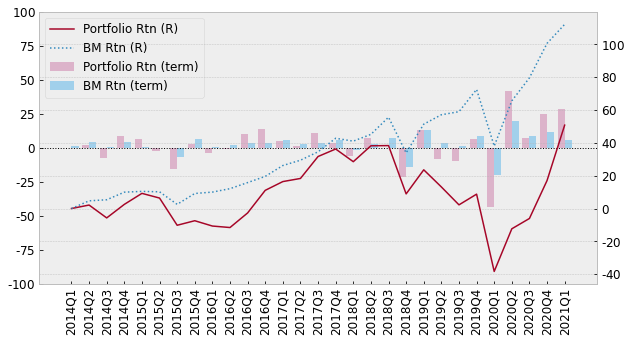

In [34]:
# 주가 수익비율(PER) + 순이익 증가율(Net Income Growth)
s1, s2, s, signal = {}, {}, {}, {}
for t in terms:
  if list(terms).index(t) >= 12:
    prev_t = fs.quarters_before(terms, t, 12)
    data[t]['PER'] = data[t]['Price_M3'] / data[t]['EPS']
    data[t]['Net Income Growth'] = (data[t]['Net Income'] - data[prev_t]['Net Income']) / abs(data[prev_t]['Net Income'])

    s1[t] = fs.fn_score(data[t], by='PER', floor=1, cap=10, asc=True)
    s2[t] = fs.fn_score(data[t], by='Net Income Growth', floor=0, asc=False)
    s[t] = fs.combine_score(s1[t], s2[t], n=30)
    signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 8.36%
Accumulated return: 75.49%
Investment period: 7.0yrs
Sharpe ratio: 0.28
MDD: -56.19%


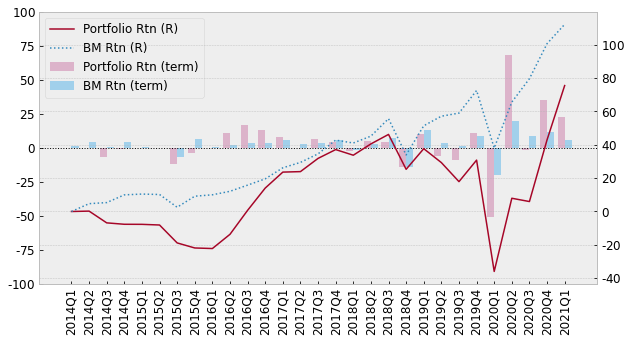

In [35]:
# 주가순자산 비율(PBR) + 영업이익 증가율(Operating Income Growth)
s1, s2, s, signal = {}, {}, {}, {}
for t in terms:
  if list(terms).index(t) >= 12:
    prev_t = fs.quarters_before(terms, t, 12)
    data[t]['PBR'] = data[t]['Price_M3'] / (data[t]['Shareholders Equity'] / data[t]['Shares']) # PBR
    data[t]['Operating Income Growth'] = (data[t]['Operating Income'] - data[prev_t]['Operating Income']) / abs(data[prev_t]['Operating Income']) # 

    s1[t] = fs.fn_score(data[t], by='PBR', floor=.1, cap=1, asc=True)
    s2[t] = fs.fn_score(data[t], by='Operating Income Growth', floor=0, asc=False)
    s[t] = fs.combine_score(s1[t], s2[t], n=30)
    signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

### 6. 부지런한 기업, 회전율 지표
- 회전율 지표
> - 총자산 회전율 : 자산대비 매출측정
>> - 총자산 회전율이 낮으면 기업이 비효율적으로 운영되는 것이다.
>> $$총자산 회전율 = \frac{매출액(Revenue)}{총자본(Total\,Assets,\,averaged)}$$
> - 매출채권 회전율 : 매출채권대비 매출 측정
>> - 외상으로 물건을 파는 일이 줄었다는 뜻이며, 제품의 경쟁력이 높아지거나 거래처의 질이 높아진 것이다.
>> $$매출채권 회전율 = \frac{매출액(Revenue)}{매출\,채권(Receivables,\,averaged)}$$
> - 재고자산 회전율 : 재고대비 매출원가 측정
>> - 재고자산 회전율이 높으면 물건을 만들면 바로 팔린다는 뜻  
>> - 하지만 너무 높을 경우, 공급이 수요를 못 따라가는 것으로 볼 수 있다.
>> $$재고자산 회전율 = \frac{매출원가(Cost\,of\,Revenue)}{재고\,자산(Inventory,\,averaged)}$$

In [36]:
df = fs.fn_single(otp='16487125231099712210', symbol='F', window='T') # 포드의 재무제표 데이터

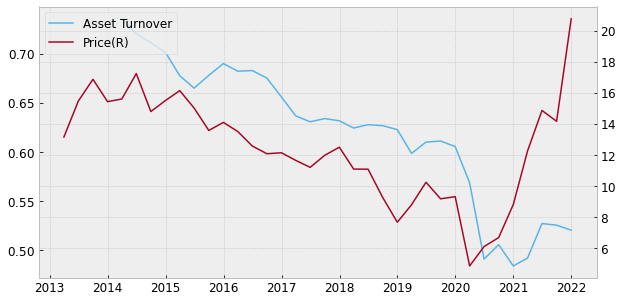

In [37]:
# 총자산 회전율 : 자산대비 매출 측정
df['Avg Assets'] = (df['Total Assets'] + df['Total Assets'].shift(4)) / 2
df['Asset Turnover'] = df['Revenue'] / df['Avg Assets']
fs.draw_chart(df, left='Asset Turnover', right='Price')

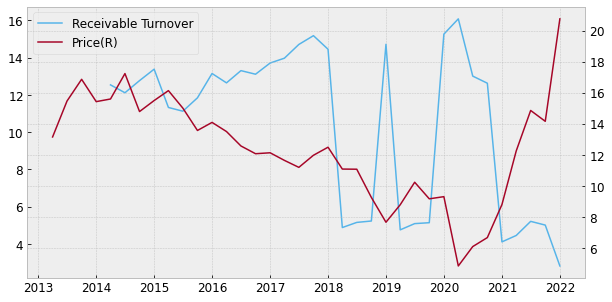

In [38]:
# 매출채권 회전율
df['Avg Receivables'] = (df['Receivables'] + df['Receivables'].shift(4)) / 2
df['Receivable Turnover'] = df['Revenue'] / df['Avg Receivables']
fs.draw_chart(df, left='Receivable Turnover', right='Price')

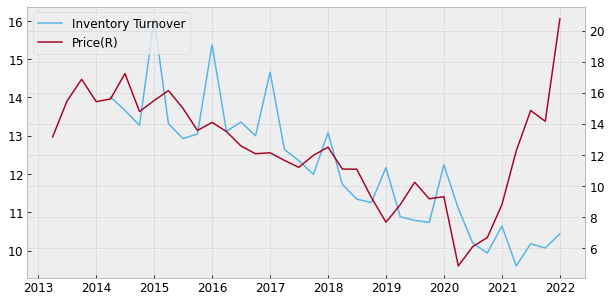

In [39]:
# 재고자산 회전율
df['Avg Inventory'] = (df['Inventory'] + df['Inventory'].shift(4)) / 2
df['Inventory Turnover'] = df['COGS'] / df['Avg Inventory']
fs.draw_chart(df, left='Inventory Turnover', right='Price')

- 재무상태표
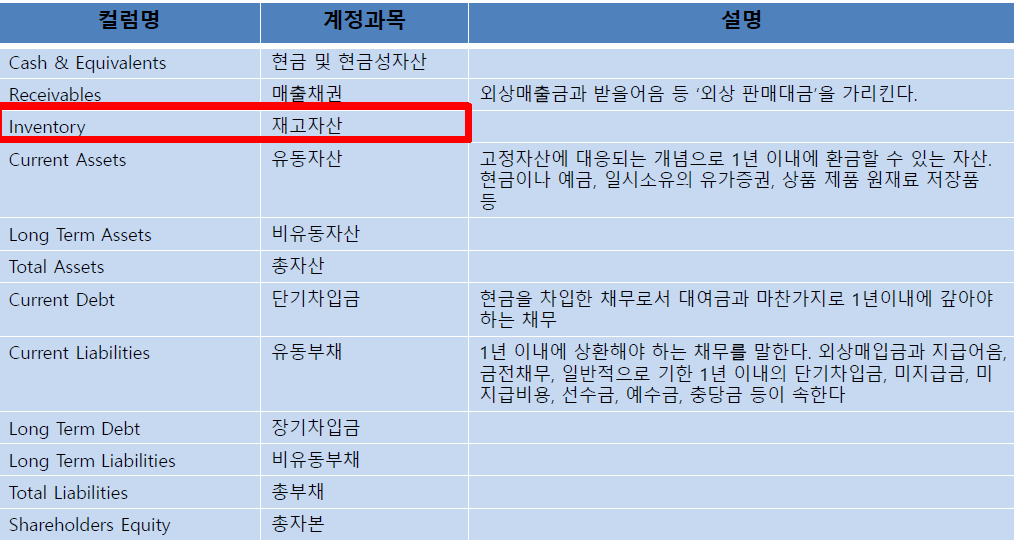

- 손익계산서
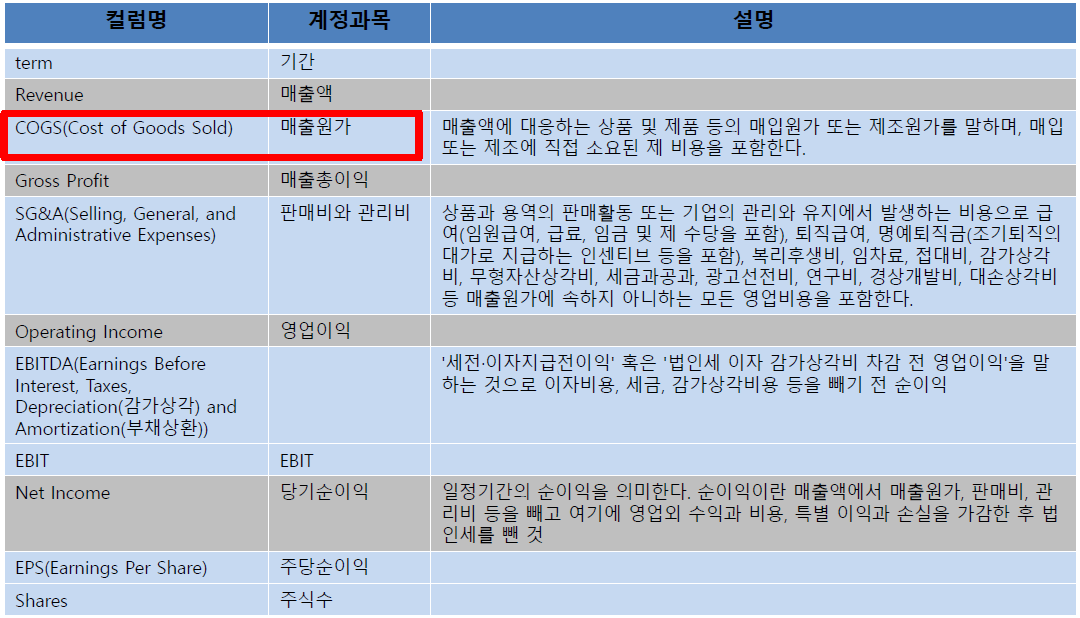

CAGR: 12.68%
Accumulated return: 230.18%
Investment period: 10.0yrs
Sharpe ratio: 0.92
MDD: -25.88%


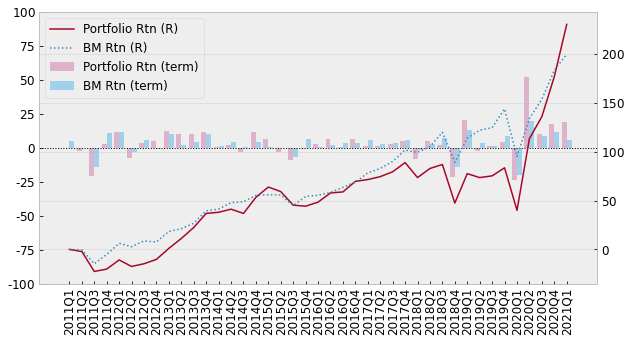

In [41]:
# 총자산 회전율 백테스팅
s, signal = {}, {}
for t in terms:
  prev_t = fs.quarters_before(terms, t, 4)
  data[t]['Avg Assets'] = (data[t]['Total Assets'] + data[prev_t]['Total Assets']) / 2
  data[t]['Assets Turnover'] = data[t]['Revenue'] / data[t]['Avg Assets']
  s[t] = fs.fn_filter(data[t], by='Assets Turnover', floor=0, n=30, asc=False)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 12.84%
Accumulated return: 234.94%
Investment period: 10.0yrs
Sharpe ratio: 1.01
MDD: -31.68%


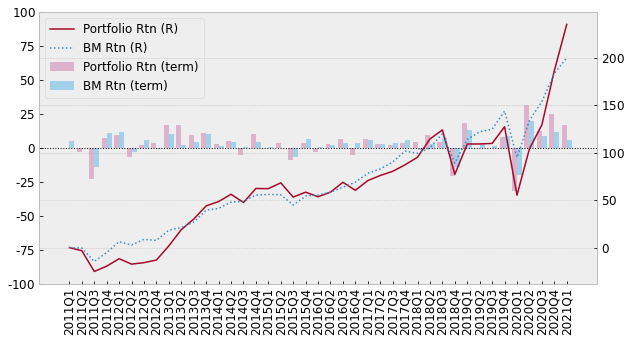

In [42]:
# GP/E 백테스팅
s, signal = {}, {}
for t in terms:
  prev_t = fs.quarters_before(terms, t, 4)
  data[t]['Avg Equity'] = (data[t]['Shareholders Equity'] + data[prev_t]['Shareholders Equity']) /2
  data[t]['GP/E'] = data[t]['Gross Profit'] / data[t]['Avg Equity']
  data[t].loc[(data[t]['Gross Profit'] <0) | (data[t]['Avg Equity'] < 0) | (data[t]['Shareholders Equity'] <0), 'GP/E'] = float('nan')
  s[t] = fs.fn_filter(data[t], by='GP/E', floor=0, n=30, asc=False)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 7.47%
Accumulated return: 105.69%
Investment period: 10.0yrs
Sharpe ratio: 0.48
MDD: -37.71%


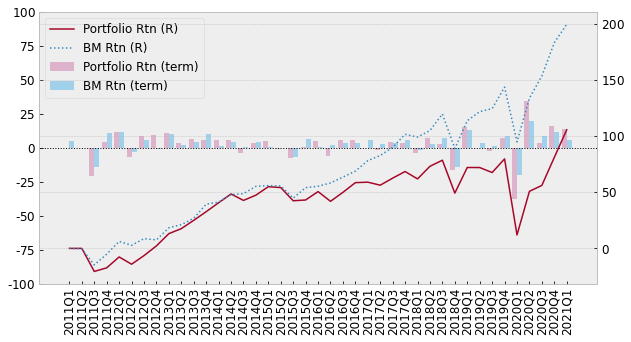

In [43]:
# S/E, Equity Turnover
s, signal = {}, {}
for t in terms:
  prev_t = fs.quarters_before(terms, t, 4)
  data[t]['Avg Equity'] = (data[t]['Shareholders Equity'] - data[prev_t]['Shareholders Equity']) /2
  data[t]['Equity Turnover'] = data[t]['Revenue'] / data[t]['Avg Equity']
  s[t] = fs.fn_filter(data[t], by='Equity Turnover', floor=0, n=30, asc=False)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 15.55%
Accumulated return: 324.96%
Investment period: 10.0yrs
Sharpe ratio: 1.31
MDD: -23.56%


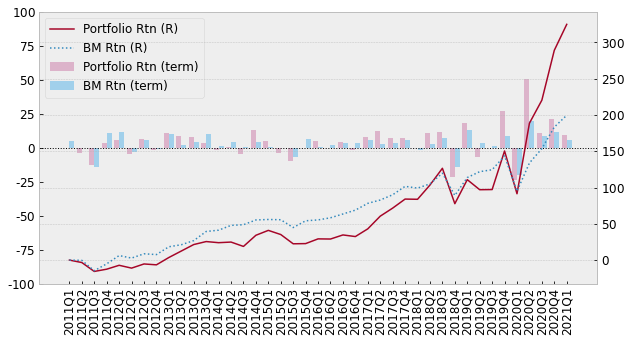

In [44]:
# 매출채권 회전율(Receivable Turnover)
s, signal = {}, {}
for t in terms:
  prev_t = fs.quarters_before(terms, t, 4)
  data[t]['Avg Receivables'] = (data[t]['Receivables'] + data[prev_t]['Receivables']) / 2
  data[t]['Receivables Turnover'] = data[t]['Revenue'] / data[t]['Avg Receivables']
  s[t] = fs.fn_filter(data[t], by='Receivables Turnover', floor=0, n=30, asc=False)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 16.15%
Accumulated return: 347.34%
Investment period: 10.0yrs
Sharpe ratio: 1.44
MDD: -31.75%


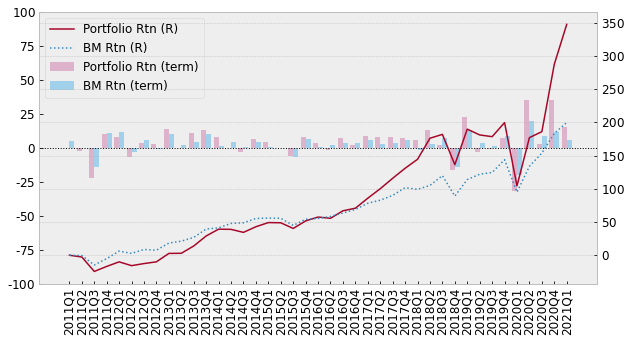

In [47]:
# 재고자산 회전율(Inventory Turnover)
s, signal = {}, {}
for t in terms:
  prev_t = fs.quarters_before(terms, t, 4)
  data[t]['Avg Inventory'] = (data[t]['Inventory'] + data[prev_t]['Inventory']) / 2
  data[t]['Inventory Turnover'] = data[t]['COGS'] / data[t]['Avg Inventory']

  s[t] = fs.fn_filter(data[t], by='Inventory Turnover', floor=0, n=30, asc=False)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

### 7. 해자가 있는 기업, 이익률 지표
- 기업에도 기업을 지키는 강력한 경쟁 요소를 경제적 해자라고 한다.
- 경제적 해자를 이익률로 대체해서 측정하기도 한다.

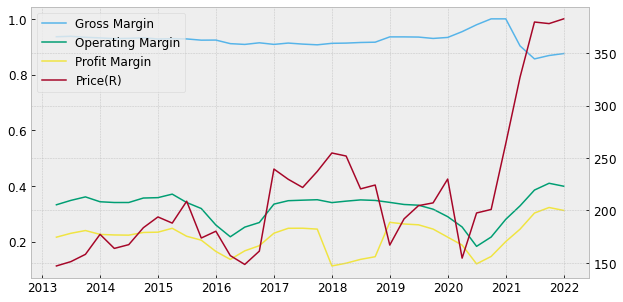

In [50]:
# 골드만삭스(GS)의 이익률 비교
df = fs.fn_single(otp='16487125231099712210', symbol='GS', window='T')
df['Gross Margin'] = df['Gross Profit'] / df['Revenue'] # 매출 총이익률
df['Operating Margin'] = df['Operating Income'] / df['Revenue'] # 영업 이익률
df['Profit Margin'] = df['Net Income'] / df['Revenue'] # 순이익률
fs.draw_chart(df, left=['Gross Margin', 'Operating Margin', 'Profit Margin'], right='Price')

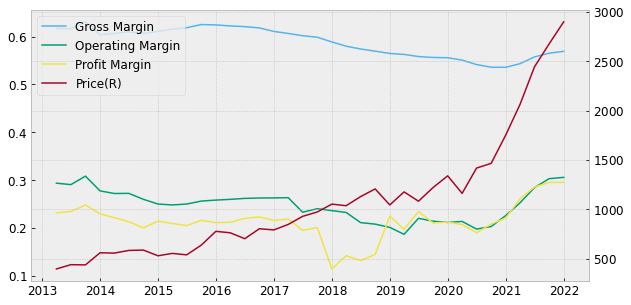

In [51]:
# 구글(GOOGL)의 이익률 비교
df = fs.fn_single(otp='16487125231099712210', symbol='GOOGL', window='T')
df['Gross Margin'] = df['Gross Profit'] / df['Revenue'] # 매출 총이익률
df['Operating Margin'] = df['Operating Income'] / df['Revenue'] # 영업 이익률
df['Profit Margin'] = df['Net Income'] / df['Revenue'] # 순이익률
fs.draw_chart(df, left=['Gross Margin', 'Operating Margin', 'Profit Margin'], right='Price')

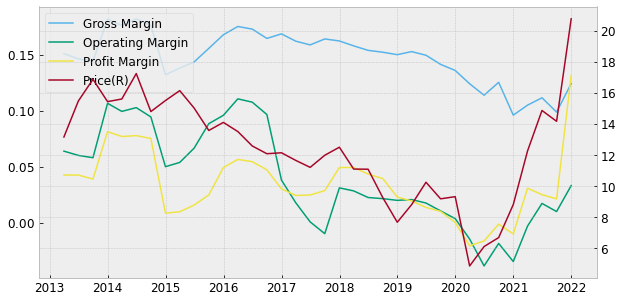

In [52]:
# 포드(F)의 이익률 비교
df = fs.fn_single(otp='16487125231099712210', symbol='F', window='T')
df['Gross Margin'] = df['Gross Profit'] / df['Revenue'] # 매출 총이익률
df['Operating Margin'] = df['Operating Income'] / df['Revenue'] # 영업 이익률
df['Profit Margin'] = df['Net Income'] / df['Revenue'] # 순이익률
fs.draw_chart(df, left=['Gross Margin', 'Operating Margin', 'Profit Margin'], right='Price')

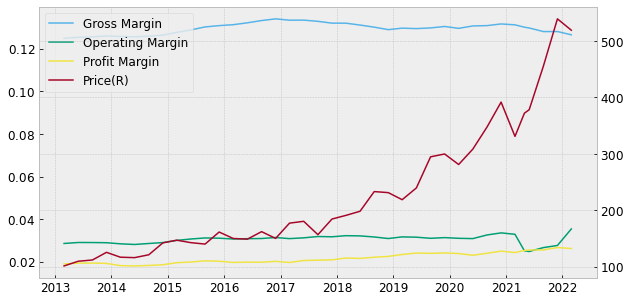

In [53]:
# 코스트코(COST)의 이익률 비교
df = fs.fn_single(otp='16487125231099712210', symbol='COST', window='T')
df['Gross Margin'] = df['Gross Profit'] / df['Revenue'] # 매출 총이익률
df['Operating Margin'] = df['Operating Income'] / df['Revenue'] # 영업 이익률
df['Profit Margin'] = df['Net Income'] / df['Revenue'] # 순이익률
fs.draw_chart(df, left=['Gross Margin', 'Operating Margin', 'Profit Margin'], right='Price')

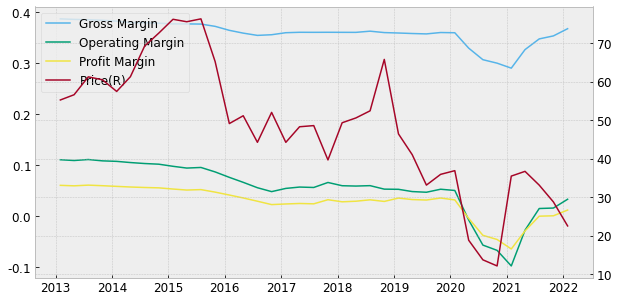

In [54]:
# 노드스트롬(JWN)의 이익률 비교
df = fs.fn_single(otp='16487125231099712210', symbol='JWN', window='T')
df['Gross Margin'] = df['Gross Profit'] / df['Revenue'] # 매출 총이익률
df['Operating Margin'] = df['Operating Income'] / df['Revenue'] # 영업 이익률
df['Profit Margin'] = df['Net Income'] / df['Revenue'] # 순이익률
fs.draw_chart(df, left=['Gross Margin', 'Operating Margin', 'Profit Margin'], right='Price')

- 이익률은 산업별, 기업 별로 천차만별로 측정된다.
- 보다 정확한 이익률 지표 분석을 위해서는 산업군 별로 비교하는 것이 더 좋을 수 있다.
> $$매출\,총\,이익률(Gross\,Margin) = \frac{매출\,총\,이익(Gross\,Profit)}{매출액(Revenue)}$$

CAGR: 11.86%
Accumulated return: 206.93%
Investment period: 10.0yrs
Sharpe ratio: 0.78
MDD: -29.40%


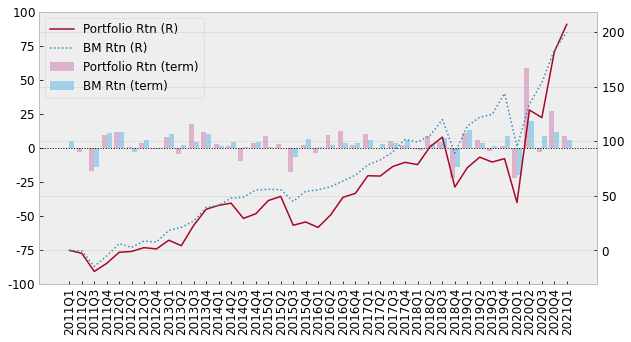

In [59]:
# Gross Margin
s, signal = {}, {}
for t in terms:
  data[t]['Gross Margin'] = data[t]['Gross Profit'] / data[t]['Revenue']
  s[t] = fs.fn_filter(data[t], by='Gross Margin', floor=0, n=30, asc=False)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

In [60]:
# 특정산업군 적용 Gross Margin 비교
# Example로 2020년 3분기 산업군 리스트 확인
sector_info = fs.sector_info(data['2020Q3'])
sector_info

sector
Basic Materials           [Aluminum, Gold, Silver, Specialty Chemicals, ...
Communication Services    [Entertainment, Broadcasting, Telecom Services...
Consumer Cyclical         [Specialty Retail, Auto & Truck Dealerships, G...
Consumer Defensive        [Beverages Brewers, Farm Products, Education &...
Energy                    [Oil & Gas Midstream, Oil & Gas E&P, Oil & Gas...
Financial Services        [Banks Regional, Insurance Diversified, Credit...
Healthcare                [Diagnostics & Research, Drug Manufacturers Ge...
Industrials               [Airlines, Building Products & Equipment, Airp...
Other                                                               [Other]
Real Estate               [Reit Mortgage, Reit Diversified, Reit Residen...
Technology                [Semiconductors, Consumer Electronics, Softwar...
Utilities                 [Utilities Regulated Electric, Utilities Diver...
Name: industry, dtype: object

CAGR: 11.86%
Accumulated return: 206.93%
Investment period: 10.0yrs
Sharpe ratio: 0.78
MDD: -29.40%


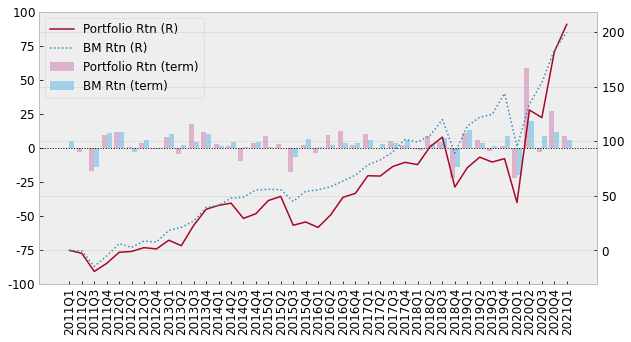

In [71]:
# 선택한 산업군에 대한 Gross Margin 백테스팅
s, signal = {}, {}
for t in terms:
  data[t]['Gross Margin'] = data[t]['Gross Profit'] / data[t]['Revenue'] * 100
  s[t] = fs.sector_filter(df=data[t], sector=['Technoloty']) # 분기별 'Technology' 산업군 추출
  s[t] = fs.fn_filter(data[t], by='Gross Margin', floor=0, n=30, asc=False)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

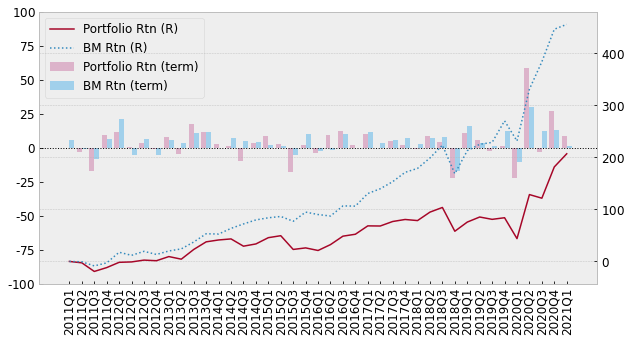

In [70]:
# 'Technology' 산업군 백테스팅 비교를 위해 관련 ETF인 QQQ 벤치마크
fs.draw_return(df, bm='QQQ')

CAGR: -0.93%
Accumulated return: -8.97%
Investment period: 10.0yrs
Sharpe ratio: -0.05
MDD: -52.13%


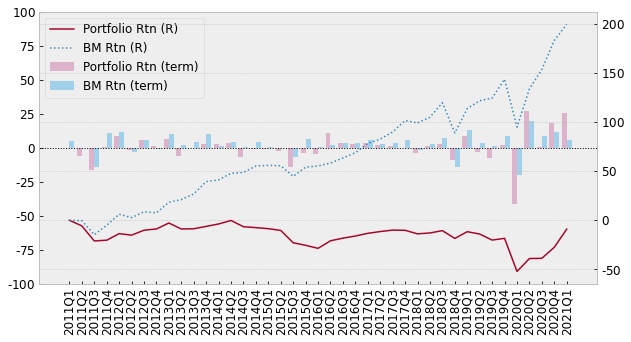

In [72]:
# 영업이익률(Operating Margin) 백테스팅
s, signal = {}, {}
for t in terms:
  data[t]['Operating Margin'] = data[t]['Operating Income'] / data[t]['Revenue'] * 100
  s[t] = fs.sector_filter(df=data[t], sector=['Technoloty']) # 분기별 'Technology' 산업군 추출
  s[t] = fs.fn_filter(data[t], by='Operating Margin', floor=0, n=30, asc=False)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

#### 지분가치가 훼손되는 주식
- 주식분할 : 기본에 발행한 주식의 수를 일정 배율만큼 늘리는 것
> - 투자자에게 직접적인 영향이 없다
>- 주식의 수가 배수적으로 늘어남 -> 주식수 증가폭이 크다.

- 유상증자 : 기존에 발행한 주식의 수에서 추가로 주식을 발행하는 것
> 투자자에게 직접적인 영향을 끼친다.
>- 주식수가 점진적으로 늘어남 -> 주식수 증가폭이 작다
---
- 주식 수가 줄어드는 좋은 예
> - 기업이 주주가치 극대화를 위해 이익잉여금으로 주식을 사들여 자사주 소각을 하는 경우
- 유상증자가 항상 좋은 예
> 새로운 사업을 시작하기 위해 자본을 모집하는 경우

In [73]:
# 2020년 유상증자를 실행한 테슬라의 재무제표 데이터 불러오기
df = fs.fn_single(otp='16487125231099712210', symbol='TSLA', window='T')
df.columns

Index(['Revenue', 'COGS', 'Gross Profit', 'SG&A', 'Operating Income',
       'Net Income', 'EPS', 'EBITDA', 'EBIT', 'Shares', 'Cash & Equivalents',
       'Receivables', 'Inventory', 'Current Assets', 'Long Term Assets',
       'Total Assets', 'Current Debt', 'Current Liabilities', 'Long Term Debt',
       'Long Term Liabilities', 'Total Liabilities', 'Shareholders Equity',
       'Depreciation', 'Operating Cash Flow', 'Capital Expenditure',
       'Investing cash flow', 'Dividends', 'Financing cash flow', 'Price'],
      dtype='object')

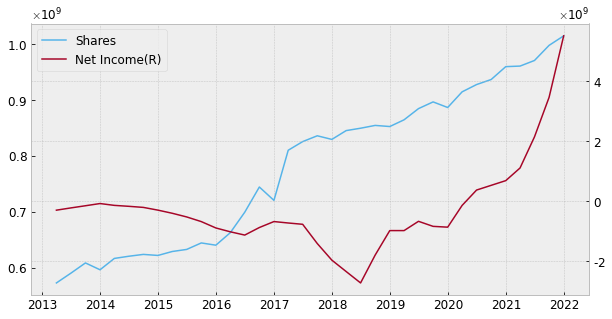

In [74]:
fs.draw_chart(df, left='Shares', right='Net Income')

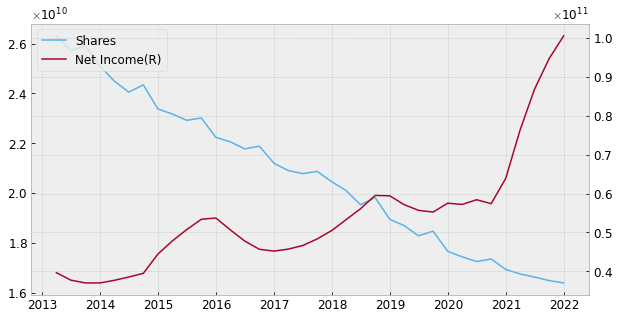

In [75]:
# 애플 주식 수 변동 확인
df = fs.fn_single(otp='16487125231099712210', symbol='AAPL', window='T')
fs.draw_chart(df, left='Shares', right='Net Income')